In [1]:
# To reload modified python modules
%load_ext autoreload
%autoreload 2

This notebook is a proof of concept that the parametrized GW distance incorporates information from matrices across all parameter values.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Optimal transport
from ot.gromov import gromov_wasserstein
from utils.gw_ms import gromov_wasserstein_ms, cost_gw, cost_ms

# Graph functions
import networkx as nx
from utils.panda_functions import *

folder_figs = "figures"

# Parametrized GW distance between pandas

## Panda with ears pasted at vertices

In [3]:
params = [[25, 10, 10], [30, 12, 12]]
nPandas = len(params)
nSteps = len(params[0])

rng = np.random.default_rng(seed=5500)
std = 0.05
ear_dist = 6

Ns = []
Pandas = []
Pandas_pos = []
dm_pandas = []
lCs_pandas = []
for idx, param in enumerate(params):
    nh = param[0]
    ne1 = param[1]
    ne2 = param[2]

    if idx == 0:
        push_ears = False
    else:
        push_ears = True
    N, G, dm, lC = create_panda(
        nh,
        ne1,
        ne2,
        paste_edge=False,
        ear_dist=ear_dist,
        push_ears=push_ears,
        add_neighbors=False,
        rng=rng,
        std=std,
    )
    pos = panda_position(nh, ne1, ne2, ear_dist=ear_dist, push_ears=push_ears)

    Ns.append(N)
    Pandas.append(G)
    Pandas_pos.append(pos)
    dm_pandas.append(dm)
    lCs_pandas.append(lC)

The code below shows a pair of panda graphs, their distance matrices, and the restriction of the latter to the head and each ear.

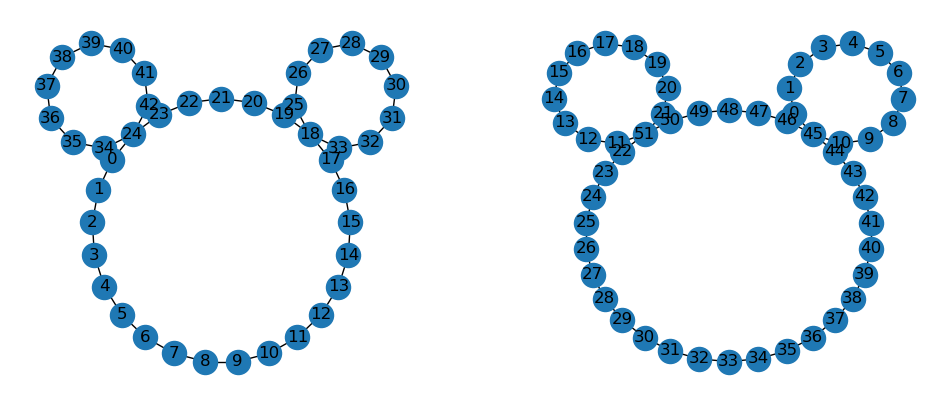

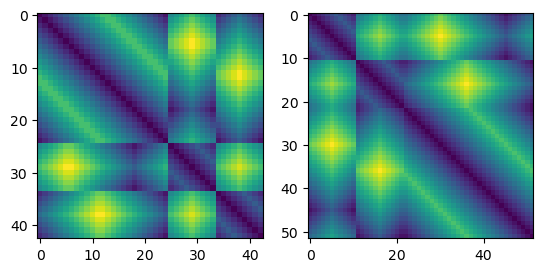

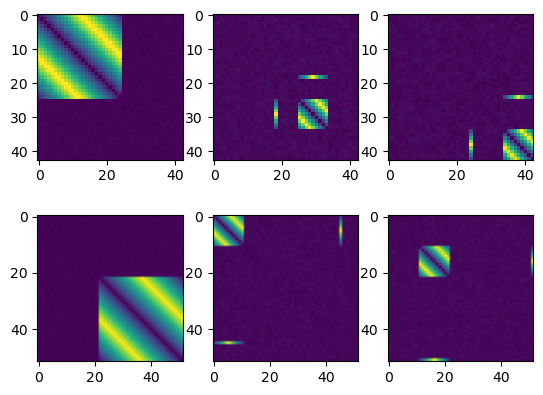

In [4]:
_ = display_ms_pandas(Pandas, Pandas_pos, dm_pandas, lCs_pandas)

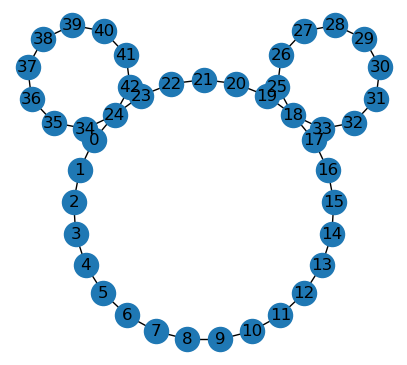

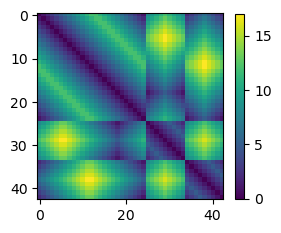

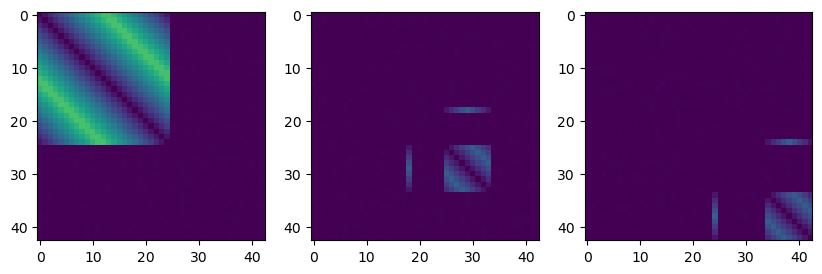

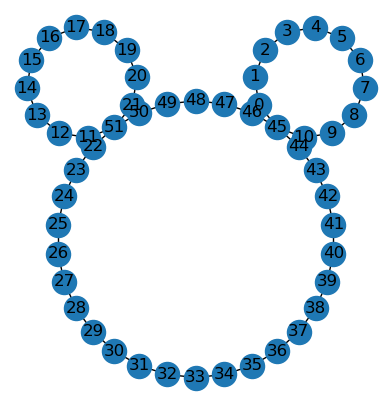

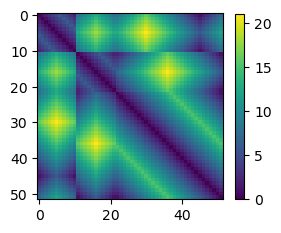

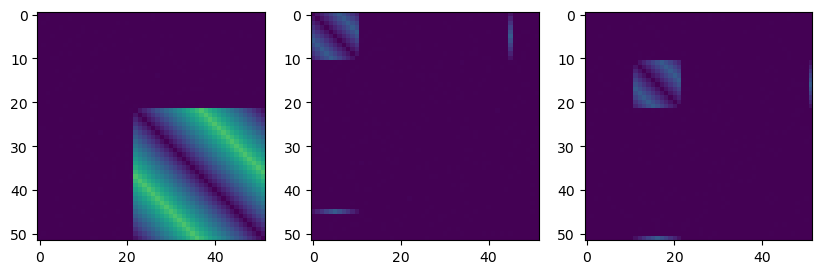

In [5]:
_ = save_pandas(Pandas, Pandas_pos, dm_pandas, lCs_pandas, folder=folder_figs)

Compute the GW distance between the full distance matrices and between the matrices corresponding to the head and each ear. Also compute the parametrized GW distance between the full pm-nets.

In [6]:
# Compute GW on distance matrix
T_gw0, log = gromov_wasserstein(dm_pandas[0], dm_pandas[1], log=True)
dGW0 = log["gw_dist"]

# Compute GW at each time
Ts_gw = []
dGWs = []
for idt in range(nSteps):
    C1 = lCs_pandas[0][idt]
    C2 = lCs_pandas[1][idt]
    T, log = gromov_wasserstein(C1, C2, log=True)

    Ts_gw.append(T)
    dGWs.append(log["gw_dist"])

# Compute MS distance
T_ms, log_ms = gromov_wasserstein_ms(lCs_pandas[0], lCs_pandas[1], log=True)
dMS = log_ms["gw_dist"]

In the first row, we show the couplings for the GW distance between the matrices restricted to the head and to each ear. The next two rows have the couplings generated by the parametrized GW distance between the pm-nets and the GW distance between the full distance matrix.

Text(0.5, 1.0, 'dGW_0 = 3.16')

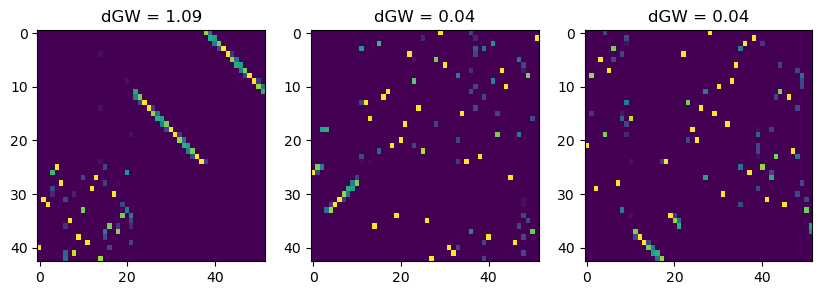

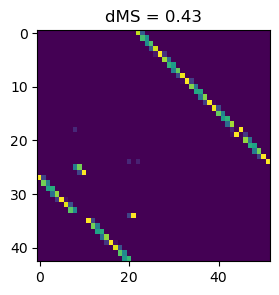

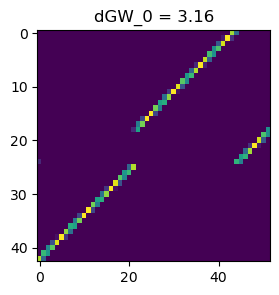

In [7]:
fig1, axes1 = plt.subplots(1, nSteps, figsize=(10, 3))

for idt in range(nSteps):
    axes1[idt].imshow(Ts_gw[idt], aspect="auto")
    axes1[idt].set_title("dGW = %0.2f" % dGWs[idt])

fig2 = plt.figure(figsize=(3, 3))
axes2 = plt.gca()
axes2.imshow(T_ms, aspect="auto")
axes2.set_title("dMS = %0.2f" % dMS)

fig4 = plt.figure(figsize=(3, 3))
axes4 = plt.gca()
axes4.imshow(T_gw0, aspect="auto")
axes4.set_title("dGW_0 = %0.2f" % dGW0)

Find the GW cost of the couplings for each GW distance and the parametrized GW distance.

In [8]:
print("GW cost of couplings")
print("GW:", cost_gw(T_gw0, dm_pandas[0], dm_pandas[1]))

for idt in range(nSteps):
    print("GW_{}: {}".format(idt, cost_gw(Ts_gw[idt], dm_pandas[0], dm_pandas[1])))

print("MS:", cost_gw(T_ms, dm_pandas[0], dm_pandas[1]))
print()

print("Multiscale cost")
print("GW:", cost_ms(T_gw0, lCs_pandas[0], lCs_pandas[1]))
print("MS:", cost_ms(T_ms, lCs_pandas[0], lCs_pandas[1]))

GW cost of couplings
GW: 3.156028286519847
GW_0: 38.273155063385786
GW_1: 36.0166422118465
GW_2: 37.051725822873884
MS: 4.843343675295479

Multiscale cost
GW: 1.1079908558081701
MS: 0.42713424351706947


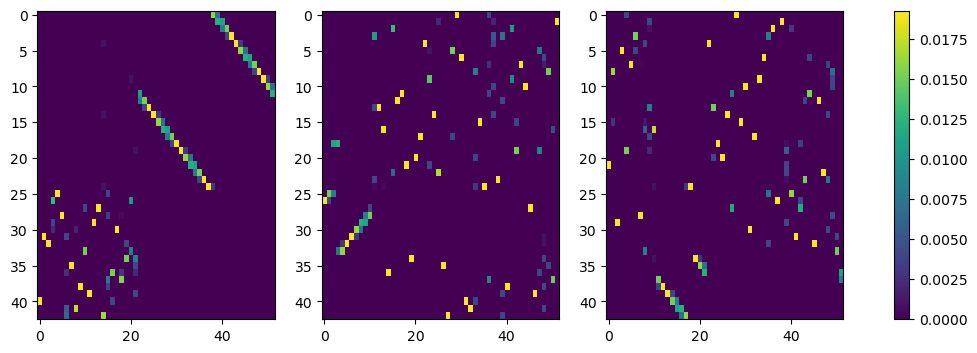

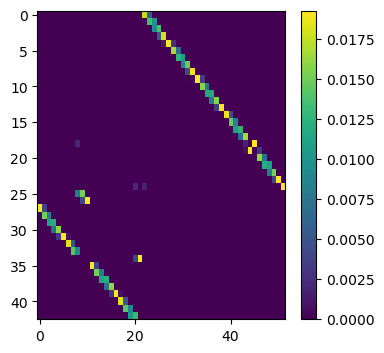

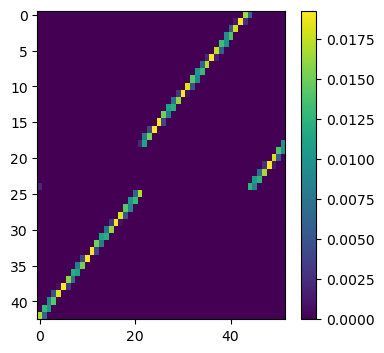

In [9]:
save_couplings(T_ms, Ts_gw, T_gw0, fs=4, folder=folder_figs)

## Average over multiple repetitions

In [10]:
nReps = 50

params = [[25, 10, 10], [30, 12, 12]]
nPandas = len(params)
nSteps = len(params[0])

rng = np.random.default_rng(seed=304)
std = 0.05
ear_dist = 6

dists_gw = np.zeros((nSteps + 1, nReps))
dists_ms = np.zeros((1, nReps))

for t in range(nReps):
    Ns = []
    Pandas = []
    Pandas_pos = []
    dm_pandas = []
    lCs_pandas = []
    for idx, param in enumerate(params):
        nh = param[0]
        ne1 = param[1]
        ne2 = param[2]

        if idx == 0:
            push_ears = False
        else:
            push_ears = True
        N, G, dm, lC = create_panda(
            nh,
            ne1,
            ne2,
            paste_edge=False,
            ear_dist=ear_dist,
            push_ears=push_ears,
            add_neighbors=True,
            rng=rng,
            std=std,
        )
        pos = panda_position(nh, ne1, ne2, ear_dist=ear_dist, push_ears=push_ears)

        Ns.append(N)
        Pandas.append(G)
        Pandas_pos.append(pos)
        dm_pandas.append(dm)
        lCs_pandas.append(lC)

    # Compute GW on distance matrix
    T_gw0, log = gromov_wasserstein(dm_pandas[0], dm_pandas[1], log=True)
    dGW0 = log["gw_dist"]

    # Compute GW at each time
    Ts_gw = []
    dGWs = []
    for idt in range(nSteps):
        C1 = lCs_pandas[0][idt]
        C2 = lCs_pandas[1][idt]
        T, log = gromov_wasserstein(C1, C2, log=True)

        Ts_gw.append(T)
        dGWs.append(log["gw_dist"])

    # Compute MS distance
    T_ms, log_ms = gromov_wasserstein_ms(lCs_pandas[0], lCs_pandas[1], log=True)
    dMS = log_ms["gw_dist"]

    # Store the GW cost of the optimal couplings
    # GW_0
    dists_gw[0, t] = cost_gw(T_gw0, dm_pandas[0], dm_pandas[1])

    # GW_t
    for idt in range(nSteps):
        dists_gw[idt + 1, t] = cost_gw(Ts_gw[idt], dm_pandas[0], dm_pandas[1])

    # MS
    dists_ms[0, t] = cost_gw(T_ms, dm_pandas[0], dm_pandas[1])

Text(0.5, 1.0, 'GW cost over multiple repetitions')

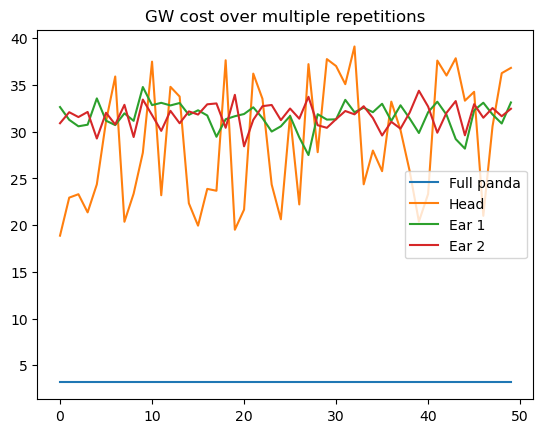

In [11]:
plt.figure()
plt.plot(dists_gw.T)
plt.legend(["Full panda", "Head", "Ear 1", "Ear 2"])
plt.title("GW cost over multiple repetitions")

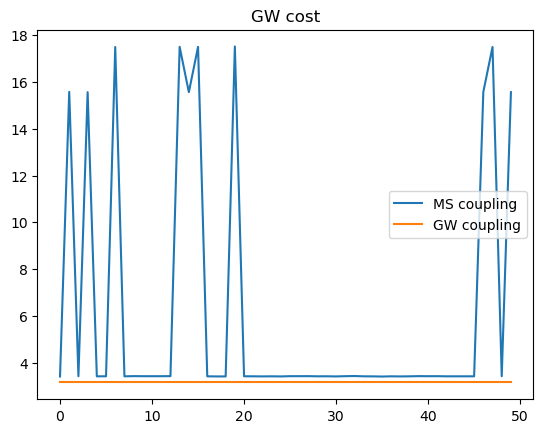

In [12]:
plt.figure()
plt.plot(dists_ms.T)
plt.plot(dists_gw[0, :].T)
plt.title("GW cost")

plt.legend(["MS coupling", "GW coupling"])

In [13]:
# Compute averages
print("GW averages, std dev:")
print(np.mean(dists_gw, axis=1))
print(np.std(dists_gw, axis=1))
print()

print("MS average, std dev:")
print(np.mean(dists_ms, axis=1))
print(np.std(dists_ms, axis=1))

GW averages, std dev:
[ 3.15602829 28.89060068 31.6450853  31.69020033]
[0.         6.53963477 1.37516353 1.27854175]

MS average, std dev:
[6.04341226]
[5.26341561]


## Pandas with ears pasted at an edge

In [14]:
params = [[25, 10, 10], [30, 12, 12]]
nPandas = len(params)
nSteps = len(params[0])

rng = np.random.default_rng(seed=304)
std = 0.05
ear_dist = 5

Ns = []
Pandas = []
Pandas_pos = []
dm_pandas = []
lCs_pandas = []
for idx, param in enumerate(params):
    nh = param[0]
    ne1 = param[1]
    ne2 = param[2]

    if idx == 0:
        push_ears = False
    else:
        push_ears = True
    N, G, dm, lC = create_panda(
        nh,
        ne1,
        ne2,
        paste_edge=True,
        ear_dist=ear_dist,
        push_ears=push_ears,
        rng=rng,
        std=std,
    )
    pos = panda_position(
        nh, ne1, ne2, paste_edge=True, ear_dist=ear_dist, push_ears=push_ears
    )

    Ns.append(N)
    Pandas.append(G)
    Pandas_pos.append(pos)
    dm_pandas.append(dm)
    lCs_pandas.append(lC)

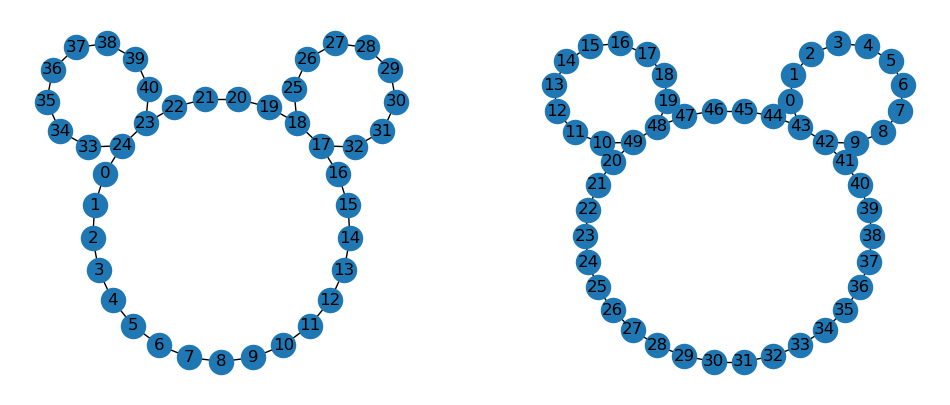

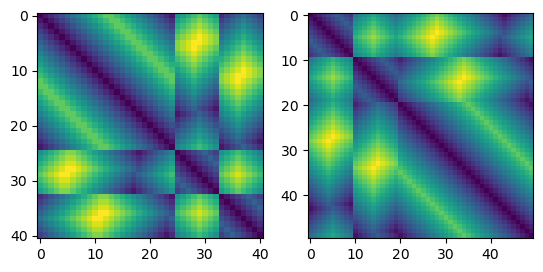

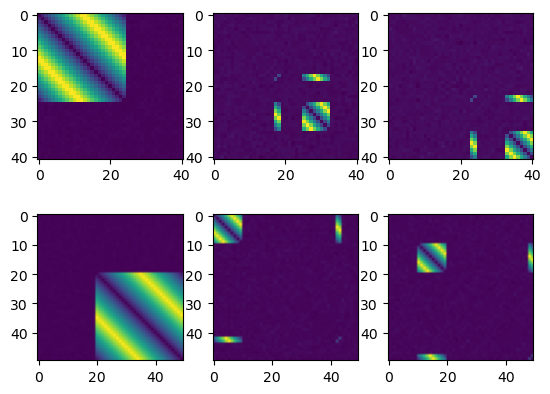

In [15]:
_ = display_ms_pandas(Pandas, Pandas_pos, dm_pandas, lCs_pandas)

In [16]:
# Compute GW at each time
Ts_gw = []
dGWs = []
for idt in range(nSteps):
    C1 = lCs_pandas[0][idt]
    C2 = lCs_pandas[1][idt]
    T, log = gromov_wasserstein(C1, C2, log=True)

    Ts_gw.append(T)
    dGWs.append(log["gw_dist"])

# Compute MS distance
T_ms, log_ms = gromov_wasserstein_ms(lCs_pandas[0], lCs_pandas[1], log=True)
dMS = log_ms["gw_dist"]

Text(0.5, 1.0, 'dMS = 0.58')

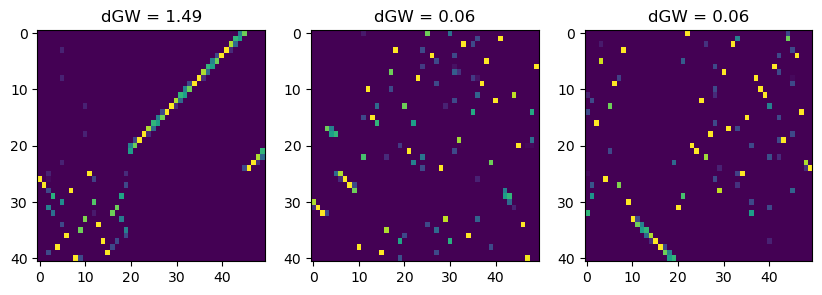

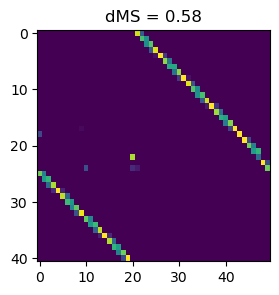

In [17]:
fig1, axes1 = plt.subplots(1, nSteps, figsize=(10, 3))

for idt in range(nSteps):
    axes1[idt].imshow(Ts_gw[idt], aspect="auto")
    axes1[idt].set_title("dGW = %0.2f" % dGWs[idt])

fig2 = plt.figure(figsize=(3, 3))
axes2 = plt.gca()
axes2.imshow(T_ms, aspect="auto")
axes2.set_title("dMS = %0.2f" % dMS)